In [1]:
from CreateDataset import get_dataset_from_graph
from CreateGraph import create_graph_from_PPI

import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
graph_path = create_graph_from_PPI('Datasets/BIOGRID-ORGANISM-Homo_sapiens-4.4.206.tab3.txt', 'C0006142', 'grafo_prova_v2')
graph_path

[+] Reading PPI...ok
[+] Creating the graph...ok
	[+] Added 19764 nodes
	[+] Added 682198 edges
[+] Removing self loops...ok
	[+] 19764 nodes
	[+] 678932 edges
[+] Taking the LCC...ok
	[+] 19761 nodes
	[+] 678932 edges
[+] Adding NeDBIT features...ok
[+] Saving graph to path: Graphs/grafo_prova_v2.gml
[i] Elapsed time: 48.04


'Graphs/grafo_prova_v2.gml'

In [3]:
dataset = get_dataset_from_graph(graph_path, 'C0006142')
dataset

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 36.049


Data(edge_index=[2, 1357864], x=[19761, 6], y=[19761], num_classes=5, train_mask=[19761], test_mask=[19761], val_mask=[19761])

In [4]:
class GNN7L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, 16, aggr='max')
        self.conv3 = SAGEConv(16, 16, aggr='max')
        self.conv4 = SAGEConv(16, 16, aggr='max')
        self.conv5 = SAGEConv(16, 16, aggr='max')
        self.conv6 = SAGEConv(16, 16, aggr='max')
        self.conv7 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
def train(model, data, epochs, lr, weight_decay, classes, model_name):    
    data = data.to(device)

    title = model_name + '_' + str(epochs) + '_' + str(weight_decay).replace('.', '_')

    model_path  = 'Models/' + title
    image_path  = 'Images/' + title
    report_path = 'Reports/' + title + '.csv'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_mask  = data['train_mask']
    test_mask   = data['test_mask']
    val_mask    = data['val_mask']

    labels = data.y
    output = ''

    # list to plot the train accuracy
    train_acc_curve = []
    train_lss_curve = []

    best_train_acc  = 0
    best_val_acc    = 0
    best_train_lss  = 999
    best_loss_epoch = 0

    for e in tqdm(range(epochs+1)):
        model.train()
        optimizer.zero_grad()
        logits      = model(data)
        output      = logits.argmax(1)
        # train_loss  = F.cross_entropy(logits[train_mask], labels[train_mask])
        train_loss  = F.nll_loss(logits[train_mask], labels[train_mask])
        train_acc   = (output[train_mask] == labels[train_mask]).float().mean()
        train_loss.backward()
        optimizer.step()

        # Append train acc. to plot curve later
        train_acc_curve.append(train_acc.item())
        train_lss_curve.append(train_loss.item())

        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Evaluation and test
        model.eval()
        logits      = model(data)
        output      = logits.argmax(1)
        val_loss    = F.nll_loss(logits[val_mask], labels[val_mask])
        val_acc     = (output[val_mask] == labels[val_mask]).float().mean()

        # Update best test/val acc.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Save model with best train loss
        if train_loss < best_train_lss:
            best_train_lss = train_loss
            best_loss_epoch = e
            torch.save(model.state_dict(), model_path)

        if e % 20 == 0 or e == epochs:
            print('[Epoch: {:04d}]'.format(e),
            'train loss: {:.4f},'.format(train_loss.item()),
            'train acc: {:.4f},'.format(train_acc.item()),
            'val loss: {:.4f},'.format(val_loss.item()),
            'val acc: {:.4f} '.format(val_acc.item()),
            '(best train acc: {:.4f},'.format(best_train_acc.item()),
            'best val acc: {:.4f},'.format(best_val_acc.item()),
            'best train loss: {:.4f} '.format(best_train_lss),
            '@ epoch', best_loss_epoch ,')')
    
    # Plot training accuracy curve
    plt.figure(figsize = (12,7))
    plt.plot(train_acc_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.show()

    plt.figure(figsize = (12,7))
    plt.plot(train_lss_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.show()

    # Load best model
    loaded_model = GNN7L_Sage(data)
    
    loaded_model = loaded_model.to(device)
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()
    logits = loaded_model(data)
    output = logits.argmax(1)

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    class_report = classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), output_dict=True)
    classification_report_dataframe = pd.DataFrame(class_report)
    classification_report_dataframe.to_csv(report_path)

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.title(model_name)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        if norm == None:
            plt.savefig(image_path + '_notNorm.png')
        else:
            plt.savefig(image_path + '_Norm.png')

    return output

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 288.6915, train acc: 0.2379, val loss: 135.1217, val acc: 0.2368  (best train acc: 0.2379, best val acc: 0.2368, best train loss: 288.6915  @ epoch 0 )
[Epoch: 0020] train loss: 16.5392, train acc: 0.2360, val loss: 5.0993, val acc: 0.4223  (best train acc: 0.2632, best val acc: 0.4334, best train loss: 16.5392  @ epoch 20 )
[Epoch: 0040] train loss: 4.2565, train acc: 0.2787, val loss: 1.7209, val acc: 0.3160  (best train acc: 0.3022, best val acc: 0.4334, best train loss: 4.2565  @ epoch 40 )
[Epoch: 0060] train loss: 2.0474, train acc: 0.2684, val loss: 1.6103, val acc: 0.2897  (best train acc: 0.3035, best val acc: 0.4334, best train loss: 2.0474  @ epoch 60 )
[Epoch: 0080] train loss: 1.6139, train acc: 0.2619, val loss: 1.4941, val acc: 0.3066  (best train acc: 0.3035, best val acc: 0.4334, best train loss: 1.6139  @ epoch 80 )
[Epoch: 0100] train loss: 1.5387, train acc: 0.2902, val loss: 1.4774, val acc: 0.3086  (best train acc: 0.3035, best val acc: 0

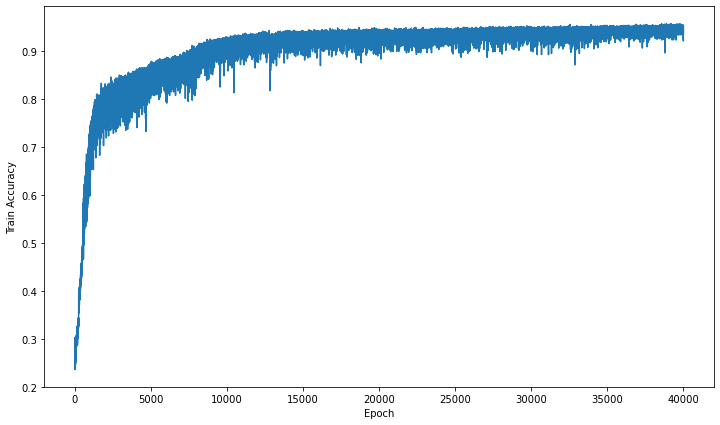

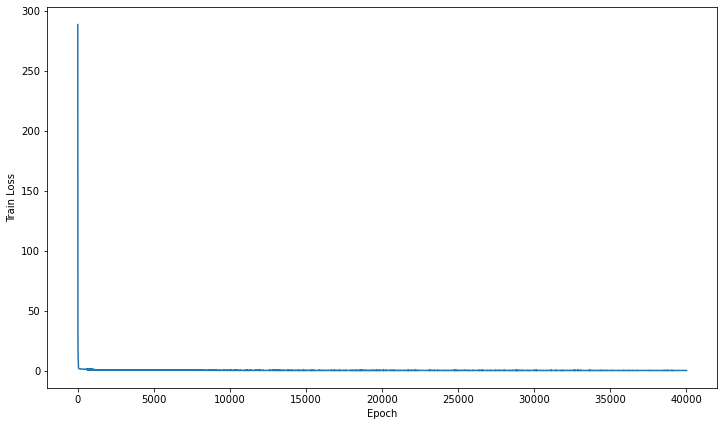

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       154
           1       0.95      0.97      0.96       703
           2       0.90      0.92      0.91       702
           3       0.96      0.91      0.94       703
           4       0.99      1.00      0.99       702

    accuracy                           0.95      2964
   macro avg       0.96      0.96      0.96      2964
weighted avg       0.95      0.95      0.95      2964



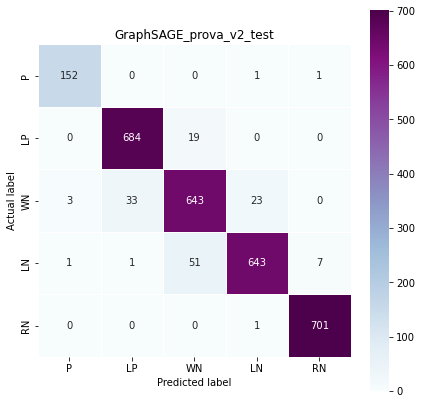

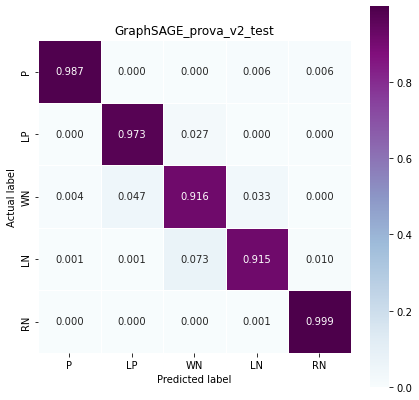

In [6]:
lr              = 0.001
epochs          = 40000
weight_decay    = 0.0005

classes         = ['P', 'LP', 'WN', 'LN', 'RN']
gnn_model = GNN7L_Sage(dataset).to(device)
pred = train(gnn_model, dataset, epochs, lr, weight_decay, classes, 'GraphSAGE_prova_v2_test')

              precision    recall  f1-score   support

           0       0.80      0.24      0.37       154
           1       0.91      0.91      0.91       703
           2       0.83      0.86      0.85       702
           3       0.85      0.93      0.89       703
           4       0.99      1.00      0.99       702

    accuracy                           0.89      2964
   macro avg       0.88      0.79      0.80      2964
weighted avg       0.89      0.89      0.88      2964



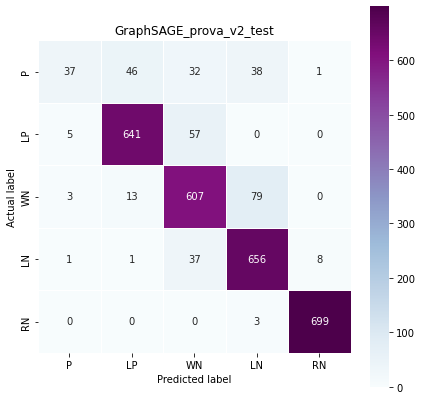

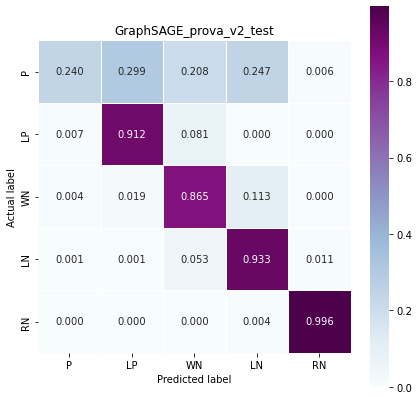

In [12]:
data = dataset.to(device)

model_name = 'GraphSAGE_prova_v2_test'

title = model_name + '_' + str(epochs) + '_' + str(weight_decay).replace('.', '_')

model_path  = 'Models/' + title
image_path  = 'Images/' + title
report_path = 'Reports/' + title + '.csv'

train_mask  = data['train_mask']
test_mask   = data['test_mask']
val_mask    = data['val_mask']

labels = data.y

loaded_model = GNN7L_Sage(data)
    
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
logits = loaded_model(data)
output = logits.argmax(1)

print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

class_report = classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), output_dict=True)
classification_report_dataframe = pd.DataFrame(class_report)
classification_report_dataframe.to_csv(report_path)

#Confusion Matrix
norms = [None, "true"]
for norm in norms:
    cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

    plt.figure(figsize=(7,7))
    
    if norm == "true":
        sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
    else:
        sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
    plt.title(model_name)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    if norm == None:
        plt.savefig(image_path + '_notNorm.png')
    else:
        plt.savefig(image_path + '_Norm.png')